<a href="https://colab.research.google.com/github/wesleiferreira98/kNN-no-Instagram/blob/main/Projeto_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import seaborn as sns
import matplotlib.pyplot as plt
import gdown

In [4]:
# URL do Google Drive
url = 'https://drive.google.com/uc?id=1MD0tpQI27v-Jmm9ZNFukUJPi0_KUn5_i'

# Caminho para salvar o arquivo temporariamente
output = '/tmp/top_insta_influencers_data.csv'

# Baixar o arquivo
gdown.download(url, output, quiet=False)

# Carregar o arquivo em um DataFrame
df = pd.read_csv(output)

# Exibindo as primeiras linhas do DataFrame para verificar
print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1MD0tpQI27v-Jmm9ZNFukUJPi0_KUn5_i
To: /tmp/top_insta_influencers_data.csv
100%|██████████| 12.6k/12.6k [00:00<00:00, 4.67MB/s]

   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  


         country  country_numeric
0          Spain                0
1  United States                0
2            NaN                0
3  United States                0
4  United States                0


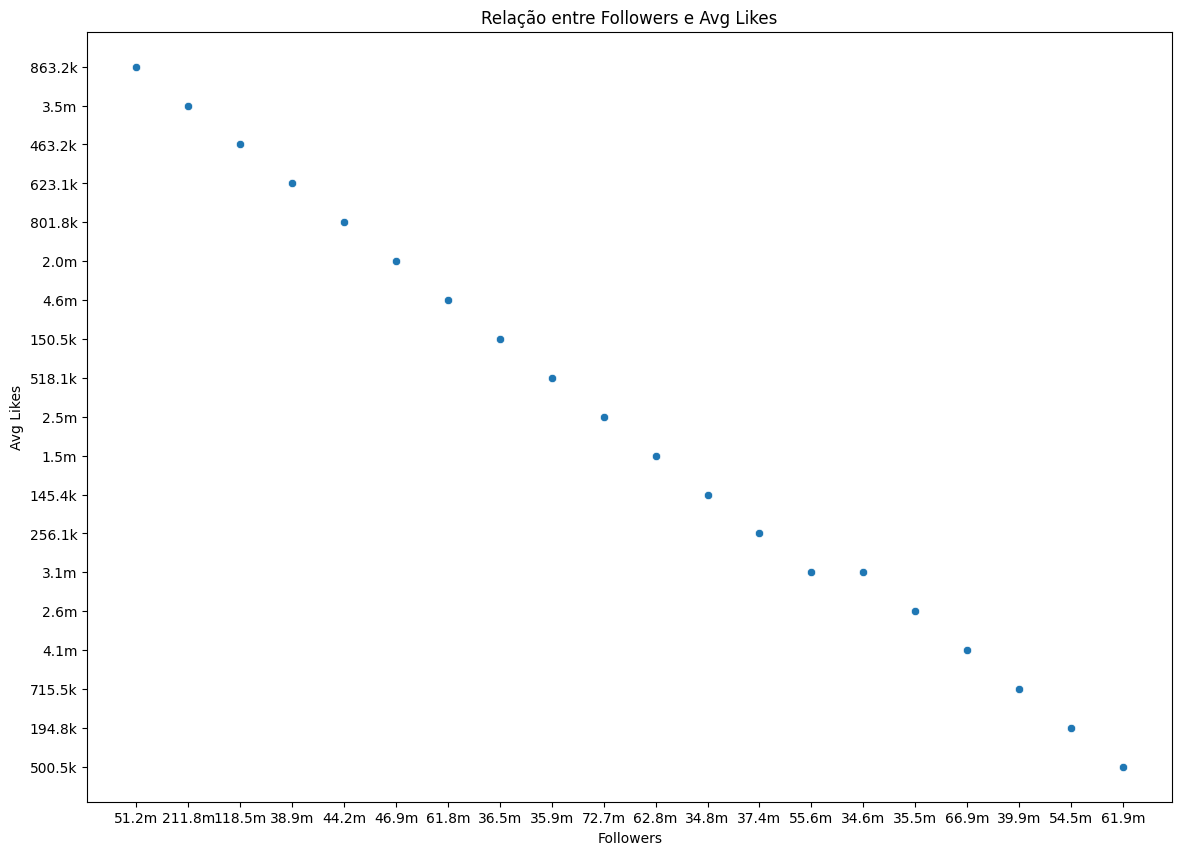

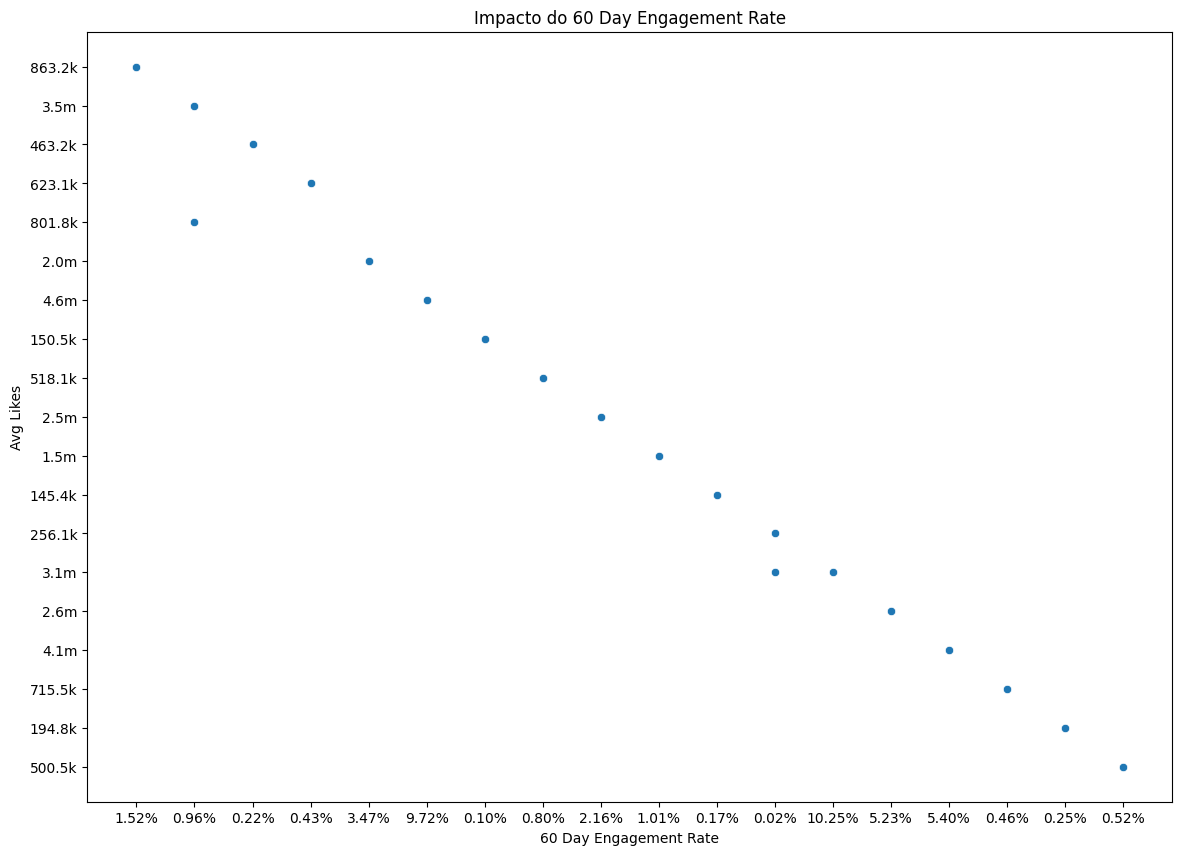

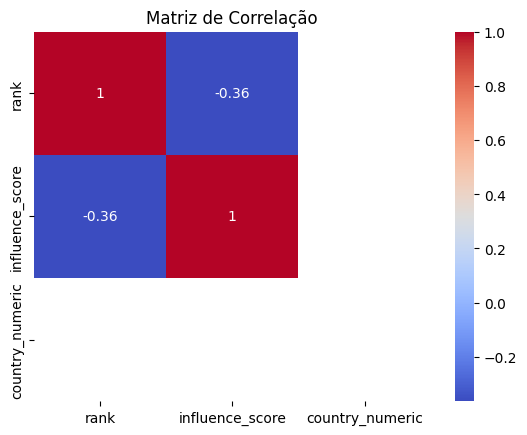

<Figure size 1400x1000 with 0 Axes>

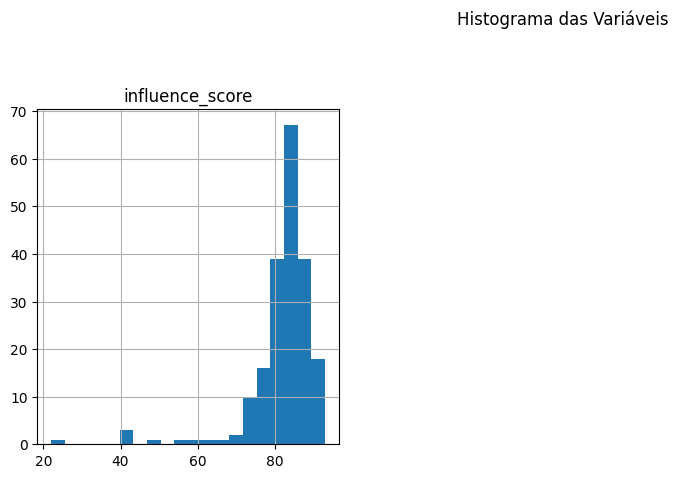

In [5]:
# Transformação de "country" em faixas numéricas por continente
continent_mapping = {
    'South America': (1, 9),
    'North America': (20, 29),
    'Europe': (40, 49),
    'Asia': (50, 59),
    'Africa': (60, 69),
    'Oceania': (70, 79)
}

# Função para mapear o país para o continente
def map_country_to_continent_range(country):
    # Verificar se o valor é nulo
    if pd.isnull(country):
        return 0  # Valor padrão para valores nulos

    # Ajustar o mapeamento com base no continente
    for continent, (start, end) in continent_mapping.items():
        if continent in country:  # Ajuste o critério conforme o necessário
            return np.random.randint(start, end + 1)
    return 0  # Valor padrão caso não encontre o país no mapeamento

# Aplicar a função
df['country_numeric'] = df['country'].apply(map_country_to_continent_range)

# Verificar a transformação
print(df[['country', 'country_numeric']].head())

sample_df = df.sample(frac=0.1,random_state=42)

# Análise Exploratória e Visualizações
plt.figure(figsize=(14,10))
sns.scatterplot(x='followers', y='avg_likes', data=sample_df)
plt.title('Relação entre Followers e Avg Likes')
plt.xlabel('Followers')
plt.ylabel('Avg Likes')
plt.show()

plt.figure(figsize=(14,10))
sns.scatterplot(x='60_day_eng_rate', y='avg_likes', data=sample_df)
plt.title('Impacto do 60 Day Engagement Rate')
plt.xlabel('60 Day Engagement Rate')
plt.ylabel('Avg Likes')
plt.show()

# Selecionar apenas colunas numéricas para a matriz de correlação
numeric_df = df.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()

# Visualizar a matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


# Histograma das variávies principais
plt.figure(figsize=(14,10))
numeric_columns = ['followers', 'avg_likes', 'total_likes', '60_day_eng_rate', 'influence_score']
df[numeric_columns].hist(bins=20, figsize=(14,10), layout=(2,3))
plt.suptitle('Histograma das Variáveis')
plt.show()

# Erro Percentual Absoluto Médio (MAPE)

#MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

#print(f"Valor do MAPE dado em percentual: {MAPE}")

